In [9]:
import numpy as np
import scipy as sp

def model(y, t, k1, k2, k3, epoRA):
    x1, x2, x3, x4 = y

    dx1 = - k1 * x1 * epoRA
    dx2 = - k2 * x2**2 + k1 * x1 * epoRA
    dx3 = - k3 * x3 + 0.5 * k2 * x2**2
    dx4 = k3 * x3

    return [dx1, dx2, dx3, dx4]



In [2]:
import pyabc
import numpy as np
import pypesto
import logging
%matplotlib inline

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Acceptor')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Epsilon')
df_logger.setLevel(logging.DEBUG)

importer = pypesto.PetabImporter.from_folder(
    "/home/yannik/benchmark-models/hackathon_contributions_new_data_format/Zheng_PNAS2012")
problem = importer.petab_problem
df = problem.measurement_df
print(df)
#print(df[['observableId', 'measurement']])
#print(df[['observableId', 'time', 'measurement']])
print(importer.create_objective()(problem.x_nominal, return_dict=True)['rdatas'][0]['y'])

problem.get_optimization_parameters()
problem.get_observables().keys()

amici_model = importer.create_model()
print(amici_model.getObservableIds())
print(problem.parameter_df)
print(len(problem.x_nominal))
problem.get_optimization_parameters()

INFO:pypesto.objective.petab_import:Using existing amici model in folder /home/yannik/Documents/Project8_pyABC_Noise/Study-ABC-Noise/study_abc_noise/jakstat/amici_models/Zheng_PNAS2012.
INFO:pypesto.objective.petab_import:Using existing amici model in folder /home/yannik/Documents/Project8_pyABC_Noise/Study-ABC-Noise/study_abc_noise/jakstat/amici_models/Zheng_PNAS2012.


    observableId preequilibrationConditionId simulationConditionId  \
0   K27me0K36me0            preequilibration          simCondition   
1   K27me0K36me0            preequilibration          simCondition   
2   K27me0K36me0            preequilibration          simCondition   
3   K27me0K36me0            preequilibration          simCondition   
4   K27me0K36me1            preequilibration          simCondition   
5   K27me0K36me1            preequilibration          simCondition   
6   K27me0K36me1            preequilibration          simCondition   
7   K27me0K36me1            preequilibration          simCondition   
8   K27me1K36me0            preequilibration          simCondition   
9   K27me1K36me0            preequilibration          simCondition   
10  K27me1K36me0            preequilibration          simCondition   
11  K27me1K36me0            preequilibration          simCondition   
12  K27me0K36me2            preequilibration          simCondition   
13  K27me0K36me2    

['inflowp',
 'k02_01',
 'k21_20',
 'k22_12',
 'k22_23',
 'k23_13',
 'k30_31',
 'k31_32',
 'k32_22',
 'sigma']

In [3]:
# data
import time

mdf = problem.measurement_df
data = {}
observables = amici_model.getObservableIds()
for observable in observables:
    data[observable] = np.array(mdf[mdf['observableId'] == observable[11:]]['measurement'])
parameters = problem.get_optimization_parameters()
pdf = problem.parameter_df.reset_index()
refval = {}
for p in parameters:
    refval[p] = float(pdf[pdf['parameterId'] == p]['nominalValue'])
    
objective = importer.create_objective()

def model(p):
    #print("start", end=" ")
    if isinstance(p, (np.ndarray, list)):
        p_vector = p
    else:
        p_vector = np.zeros(len(parameters))
        for ip, p_id in enumerate(parameters):
            p_vector[ip] = p[p_id]
            
    t0 = time.time()
    #print("m", list(p_vector), end=" ")

    rdatas =  objective(p_vector, return_dict=True)['rdatas']
    y = rdatas[0]['y']
    #print(time.time()-t0, end=" ")
    ret = {}
    for i, observable in enumerate(observables):
        ret[observable] = np.array(y[:, i])
    #print("end", end=" ")
    return ret

def get_var(p):
    var = []
    for observable in observables:
        var.extend([10**(2*p['sigma'])] * len(data[observable]))
    return np.array(var)

# prior
limits = {}
for p in parameters:
    row = pdf[pdf['parameterId'] == p]
    limits[p] = (float(row['lowerBound']), float(row['upperBound']))
prior = pyabc.Distribution(**{p: pyabc.RV('uniform', a, b-a) for p, (a,b) in limits.items()})

print(len(limits))
# abc functions
distance = pyabc.IndependentNormalKernel(var=get_var, keys=observables)
acceptor = pyabc.StochasticAcceptor()
eps = pyabc.Temperature(schemes=[pyabc.AcceptanceRateScheme(), pyabc.ExpDecayFixedRatioScheme(alpha=0.75)])

INFO:pypesto.objective.petab_import:Using existing amici model in folder /home/yannik/Documents/Project8_pyABC_Noise/Study-ABC-Noise/study_abc_noise/jakstat/amici_models/Zheng_PNAS2012.


10


In [33]:
print(problem.x_nominal)
print(model(problem.x_nominal))
print(data)

[-1.5159682952674898, 2.9988193951672297, -0.630741725766828, 2.68109795960193, 0.28180198273587803, 0.42349081778982295, -1.1551277123136001, -4.9999998124438605, -4.99999947455282, -4.9999999999999805, 2.99481075522779, -4.99999999992626, -4.9999999896302, -0.569938364856428, -4.999999999992509, -4.99987145176529, 1.07378392980943, -4.99999998476407, -4.999999999999151, -0.9706187453753949, -1.4481854451767502, -1.9740149272557699, 2.65363298331167, -0.7093963282018, -4.99999999809633, -4.9999999999999805, -4.99999981237195, -0.821771073094981, -4.99984610213653, -1.4510243457070202, 2.99968703404029, -4.999999998862441, -1.2726243778748798, 2.6295555324501003, -0.81889591101979, -4.9999999999999805, -0.10171307017624699, -4.9999967086855595, -4.9999994008315305, -0.5508265129504879, -4.99962003467971, -4.999989572738009, -0.45144917629559794, -0.198608740210104, -4.9999999999999805, -2.6308831038901697]
{'observable_K27me2K36me0': array([0.00609932, 0.00514739, 0.00303548, 0.0003939

In [40]:
def pdf_norm_method(prev_pdf_norm, get_weighted_distances, prev_temp, acceptance_rate, **kwargs):
    pdf_norm = pyabc.pdf_norm_max_found(prev_pdf_norm=prev_pdf_norm, get_weighted_distances=get_weighted_distances)
    #return np.median(get_weighted_distances()['distance'])
    if prev_temp is None:
        return pdf_norm
    #if prev_temp is None or acceptance_rate >= 0.2:
    #    return pdf_norm
    temp = 0.5 * prev_temp
    offset = temp * np.log(10)
    return max(pdf_norm - offset, prev_temp-10)#np.log(100)

transition = pyabc.LocalTransition()

acceptor = pyabc.StochasticAcceptor(pdf_norm_method=pdf_norm_method)
eps = pyabc.Temperature(schemes=[pyabc.ExpDecayFixedRatioScheme()])
sampler = pyabc.sampler.SingleCoreSampler()
abc = pyabc.ABCSMC(model, prior, distance, acceptor=acceptor, eps=eps, population_size=1000)#, sampler=sampler,)
#                   transitions=transition)
abc.new("sqlite:///h_zheng.db", data)
abc.run()

INFO:History:Start <ABCSMC(id=59, start_time=2019-12-04 23:10:45.448918, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=1.4320e+02 for t=0.
INFO:ABC:t: 0, eps: 423.5680500802556.
DEBUG:Acceptor:Encountered pd=1.4357e+02 > c=1.4320e+02, thus weight=1.0009e+00.
DEBUG:Acceptor:Encountered pd=1.7142e+02 > c=1.4320e+02, thus weight=1.0689e+00.
INFO:ABC:Acceptance rate: 1000 / 3454 = 2.8952e-01, ESS=1.0000e+03.
DEBUG:Acceptor:pdf_norm=4.1357e+02 for t=1.
DEBUG:Epsilon:Proposed temperatures: [211.7840250401278].
INFO:ABC:t: 1, eps: 211.7840250401278.
INFO:ABC:Acceptance rate: 1000 / 10898 = 9.1760e-02, ESS=1.8825e+02.
DEBUG:Acceptor:pdf_norm=2.0178e+02 for t=2.
DEBUG:Epsilon:Proposed temperatures: [105.8920125200639].
INFO:ABC:t: 2, eps: 105.8920125200639.
INFO:ABC:Acceptance rate: 1000 / 10398 = 9.6172e-02, ESS=3.1207e+02.
DEBUG:Acceptor:pdf_norm=2.9166e+02 for t=3.
DEBUG:Epsilon:Proposed temperatures: [52.94600626003195].
INFO:ABC:t: 3, eps: 52.9460062600319

KeyboardInterrupt: 

  File "/home/yannik/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py", line 1048, in wrapper
    result = na_op(lvalues, rvalues)
  File "/home/yannik/anaconda3/lib/python3.7/site-packages/scipy/linalg/lapack.py", line 603, in get_lapack_funcs
    def get_lapack_funcs(names, arrays=(), dtype=None):
  File "<ipython-input-32-0efb6a3aa45a>", line 29, in model
    rdatas =  objective(p_vector, return_dict=True)['rdatas']
KeyboardInterrupt
KeyboardInterrupt
  File "/home/yannik/pypesto/pypesto/objective/objective.py", line 233, in __call__
    result = self._call_unprocessed(x, sensi_orders, mode)
  File "/home/yannik/pypesto/pypesto/objective/objective.py", line 253, in _call_unprocessed
    result = self._call_mode_fun(x, sensi_orders)
  File "/home/yannik/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py", line 968, in na_op
    result = expressions.evaluate(op, str_rep, x, y, **eval_kwargs)
  File "/home/yannik/anaconda3/lib/python3.7/site-packages/pan

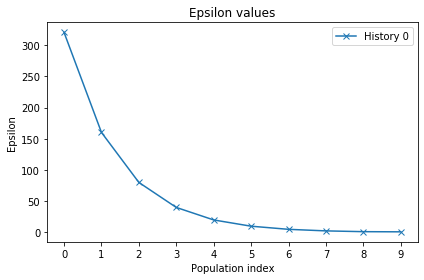

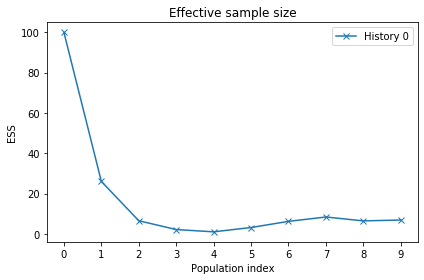

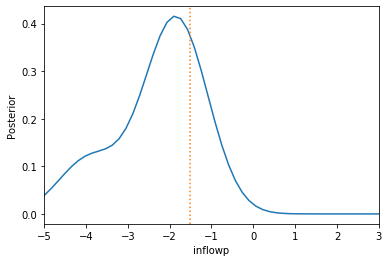

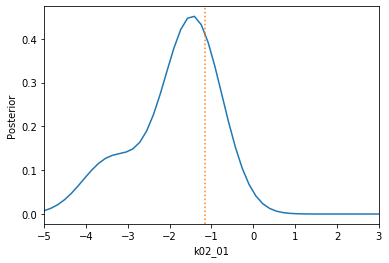

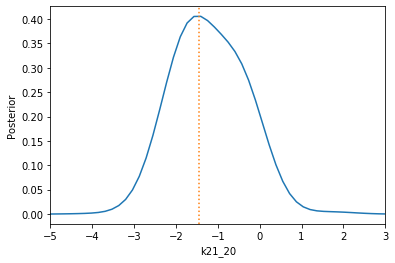

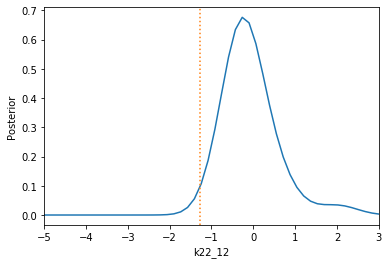

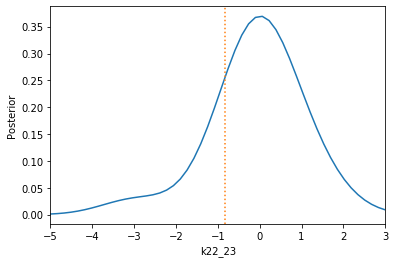

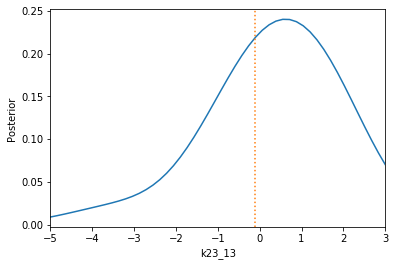

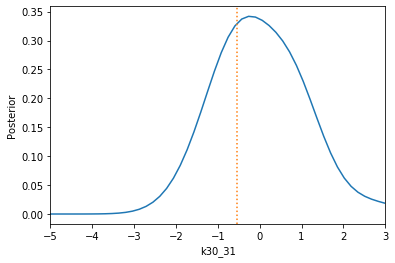

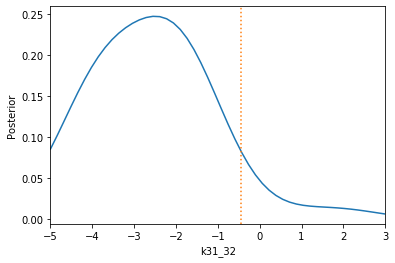

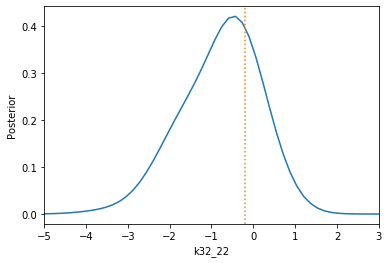

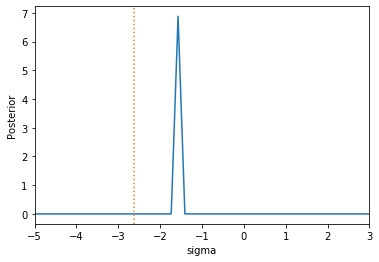

In [12]:
import pyabc
h = pyabc.History("sqlite:///h_zheng.db")
h.id-=4
pyabc.visualization.plot_epsilons(h)
pyabc.visualization.plot_effective_sample_sizes(h)
for x in parameters:
    pyabc.visualization.plot_kde_1d_highlevel(h, x=x, xmin=limits[x][0], xmax=limits[x][1], refval=refval)
#pyabc.visualization.plot_kde_matrix_highlevel(h, limits=limits, refval=refval)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe600d8358>,
      dtype=object)

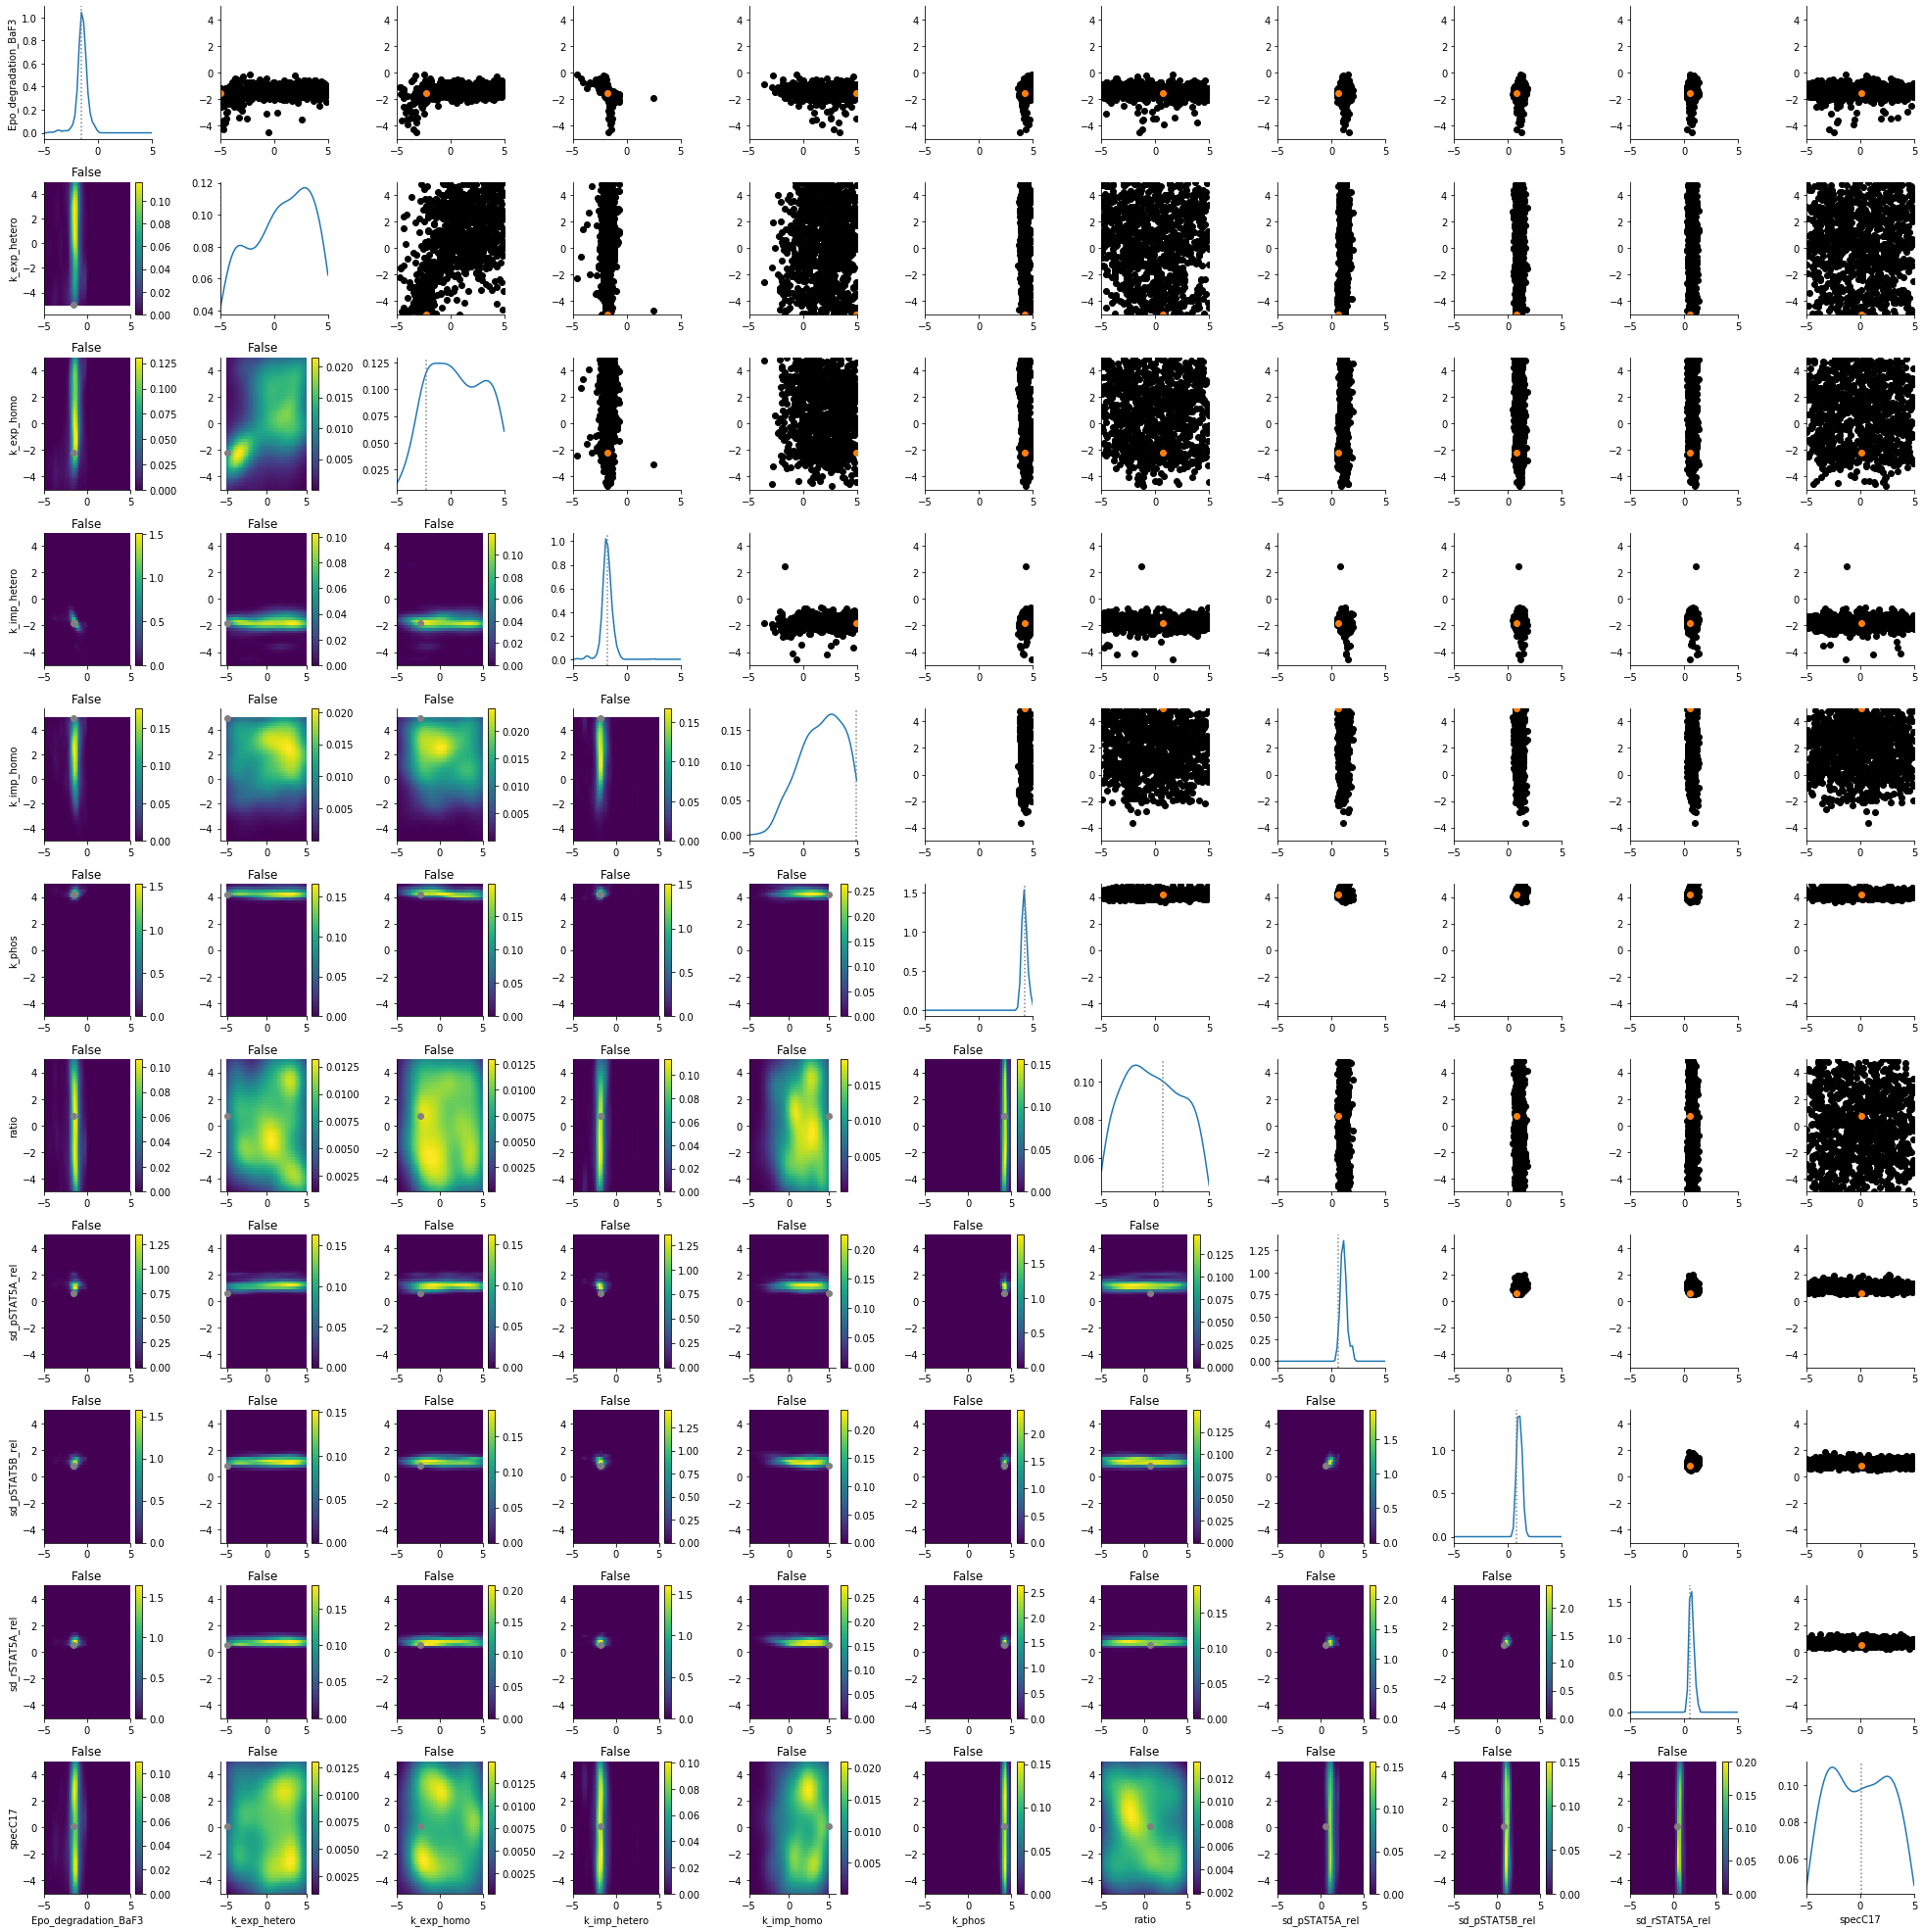

In [4]:
import pyabc
h = pyabc.History("sqlite:///h_boehm.db")
pyabc.visualization.plot_kde_matrix_highlevel(h, refval=refval, limits=limits)

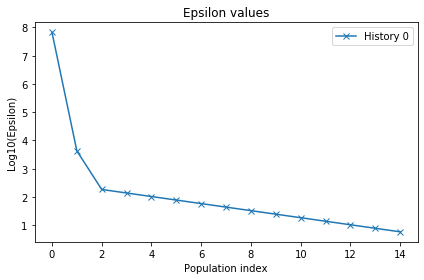

In [9]:
pyabc.visualization.plot_epsilons(h, scale="log10")

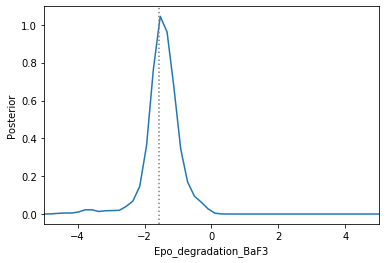

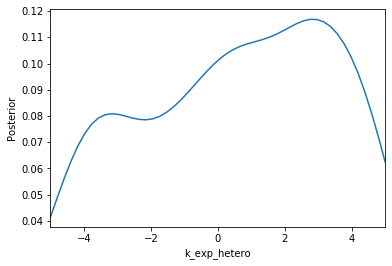

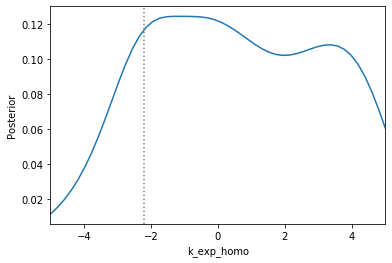

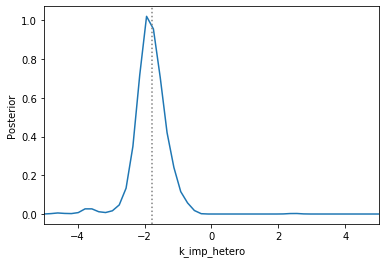

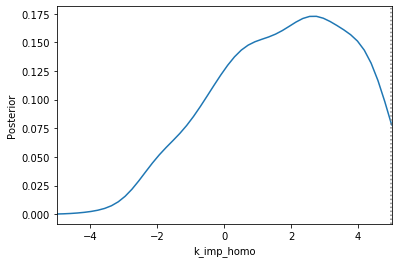

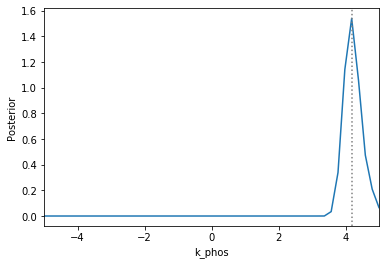

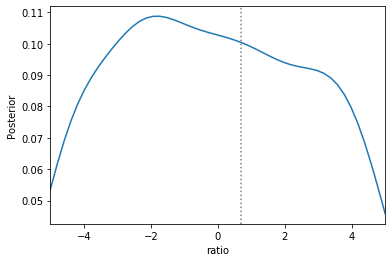

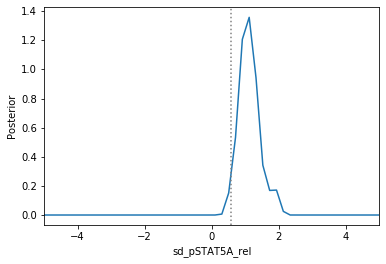

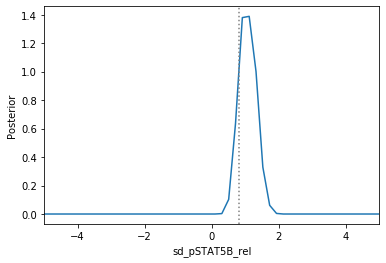

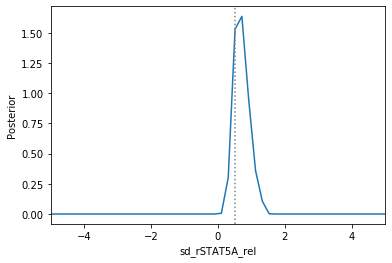

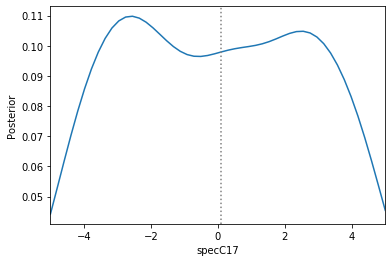

In [6]:
for p in parameters:
    pyabc.visualization.plot_kde_1d_highlevel(h, x=p, refval=refval, xmin=limits[p][0], xmax=limits[p][1])

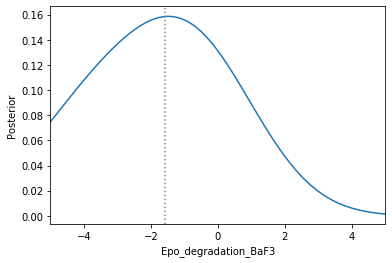

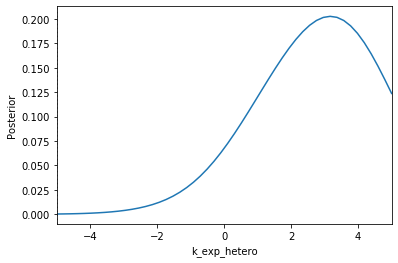

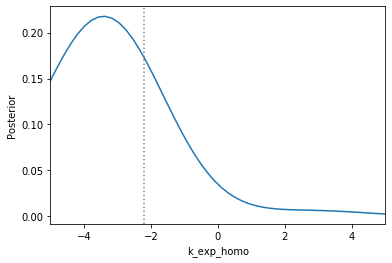

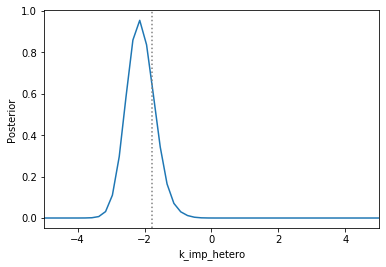

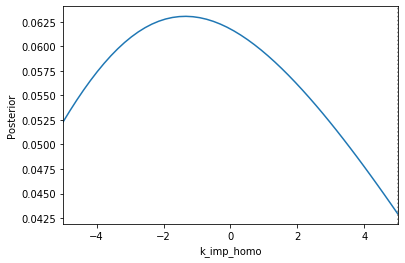

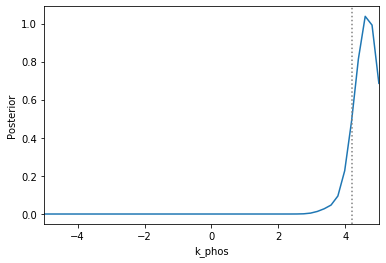

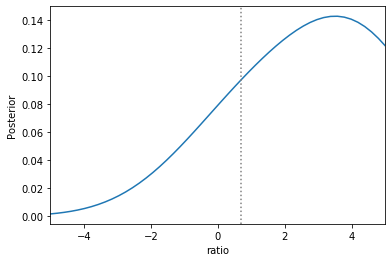

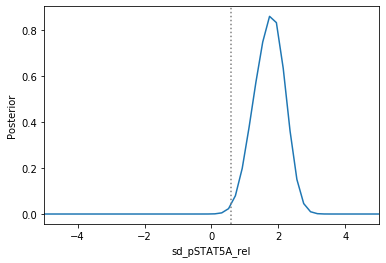

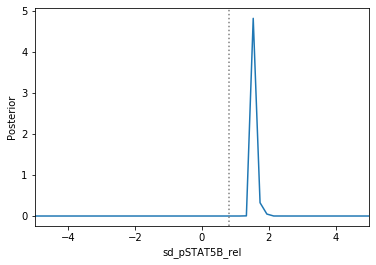

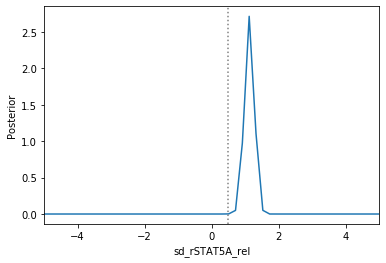

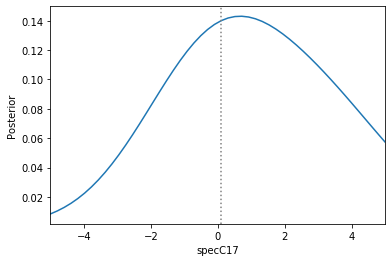

In [12]:
import pyabc
h = pyabc.History("sqlite:///h_boehm2.db")
for p in parameters:
    pyabc.visualization.plot_kde_1d_highlevel(h, x=p, refval=refval, xmin=limits[p][0], xmax=limits[p][1])